# Demo

## Setup Path

In [2]:
import sys
from pathlib import Path

# Setup path
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from src.models import UNet

## Config

In [4]:
# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints"
IMAGE_SIZE = 256

## Load Data

In [5]:
# Load models
leaf_model = UNet(in_channels=3, out_channels=1).to(DEVICE)
disease_model = UNet(in_channels=3, out_channels=1).to(DEVICE)

leaf_model.load_state_dict(
    torch.load(CHECKPOINT_DIR / "leaf_best.pth", map_location=DEVICE)
)
disease_model.load_state_dict(
    torch.load(CHECKPOINT_DIR / "disease_best.pth", map_location=DEVICE)
)

leaf_model.eval()
disease_model.eval()

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=

## Preproced Image

In [6]:
def preprocess_image(image_path):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    return img

In [7]:
# Predict masks
@torch.no_grad()
def predict(img_tensor):
    img = img_tensor.unsqueeze(0).to(DEVICE)

    leaf_pred = torch.sigmoid(leaf_model(img)) > 0.5
    img_masked = img * leaf_pred

    disease_pred = torch.sigmoid(disease_model(img_masked)) > 0.5

    return (
        leaf_pred.squeeze().cpu(),
        disease_pred.squeeze().cpu()
    )

In [8]:
# Compute severity
def compute_severity(leaf_mask, disease_mask):
    leaf_area = leaf_mask.sum()
    disease_area = disease_mask.sum()
    return (disease_area / leaf_area).item() if leaf_area > 0 else 0.0

In [14]:
# Visualization
def visualize(img, leaf_mask, disease_mask, severity, title="Inference Result"):
    img = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # -------------------------
    # Pred Leaf
    # -------------------------
    ax[0].imshow(img)
    ax[0].imshow(leaf_mask, alpha=0.4, cmap="Greens")
    ax[0].set_title("Pred Leaf")
    ax[0].axis("off")

    # -------------------------
    # Pred Disease
    # -------------------------
    ax[1].imshow(img)
    ax[1].imshow(disease_mask, alpha=0.4, cmap="Reds")
    ax[1].set_title("Pred Disease")
    ax[1].axis("off")

    # -------------------------
    # Severity Display
    # -------------------------
    ax[2].imshow(img)
    ax[2].axis("off")

    ax[2].text(
        0.98, 0.05,                       # pojok kanan bawah (relatif axes)
        f"Severity:\n{severity:.3f}",
        fontsize=10,
        ha="right",
        va="bottom",
        transform=ax[2].transAxes,
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.4",
            alpha=0.85
        )
    )

    ax[2].set_title("Severity Estimation")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## Main

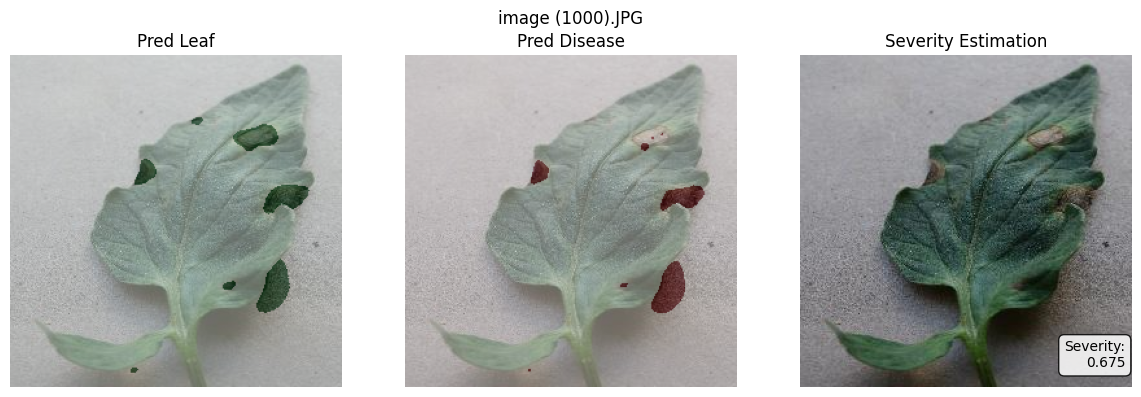

In [17]:
if __name__ == "__main__":
    # GANTI PATH GAMBAR DI SINI
    image_path = PROJECT_ROOT / "data" / "raw" / "Tomato___Early_blight" / "image (1000).JPG"

    img = preprocess_image(image_path)
    leaf_mask, disease_mask = predict(img)
    severity = compute_severity(leaf_mask, disease_mask)

    visualize(img, leaf_mask, disease_mask, severity, title=image_path.name)